In [ ]:
import os
import zipfile
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# === 1. Розпаковка ZIP ===
desktop = os.path.expanduser(r"C:\Users\anon\Desktop")
zip_path = os.path.join(desktop, "bank+marketing.zip")

with zipfile.ZipFile(zip_path, 'r') as z:
    target_name = None
    for name in z.namelist():
        if name.lower().endswith("bank-full.csv") or name.lower().endswith("bank_full.csv"):
            target_name = name
            break
    if target_name is None:
        csvs = [n for n in z.namelist() if n.lower().endswith(".csv")]
        target_name = csvs[0]
    z.extract(target_name, desktop)
    extracted_csv = os.path.join(desktop, os.path.basename(target_name))

print(f"CSV path: {extracted_csv}")

# === 2. Читання CSV ===
df = pd.read_csv(extracted_csv, sep=';')
print("\n=== ДАНІ ===")
print(f"Розмір датасету: {df.shape[0]} рядків x {df.shape[1]} колонок")
print(f"Колонки: {df.columns.tolist()}")

# === 3. Видаляємо duration ===
if 'duration' in df.columns:
    df = df.drop(columns=['duration'])
    print("Видалено колонку 'duration'")

# === 4. Цільова змінна та X/Y ===
y = df['y'].map({'yes':1, 'no':0})
X = df.drop(columns=['y'])

# === 5. Розділення колонок на числові та категоріальні ===
num_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
print(f"Числові колонки: {num_cols}")
print(f"Категоріальні колонки: {cat_cols}")

# === 6. Pipeline для препроцесингу ===
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_cols),
        ('cat', categorical_transformer, cat_cols)
    ]
)

# === 7. Train/Test split ===
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print("\n=== TRAIN / TEST ===")
print(f"Train: {X_train.shape[0]} рядків")
print(f"Test: {X_test.shape[0]} рядків")

# === 8. Підбір k та weights ===
k_values = list(range(1, 50, 2))
pipe = Pipeline(steps=[('pre', preprocessor), ('knn', KNeighborsClassifier(n_jobs=-1))])
param_grid = {'knn__n_neighbors': k_values, 'knn__weights': ['uniform', 'distance']}
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

grid = GridSearchCV(pipe, param_grid, cv=cv, scoring='accuracy', n_jobs=-1)
print("\nПочаток GridSearchCV для підбору k ...")
grid.fit(X_train, y_train)

cv_results = pd.DataFrame(grid.cv_results_)
best_params = grid.best_params_
best_score = grid.best_score_

res_by_k = {}
for k in k_values:
    mask = (cv_results['param_knn__n_neighbors'] == k)
    rows = cv_results[mask]
    if not rows.empty:
        best_for_k = rows.loc[rows['mean_test_score'].idxmax()]
        res_by_k[k] = best_for_k['mean_test_score']

k_meets = [k for k,score in res_by_k.items() if score >= 0.85]
if k_meets:
    chosen_k = min(k_meets)
    chosen_k_score = res_by_k[chosen_k]
    chosen_weights = cv_results[(cv_results['param_knn__n_neighbors']==chosen_k)].sort_values('mean_test_score', ascending=False).iloc[0]['param_knn__weights']
else:
    chosen_k = best_params['knn__n_neighbors']
    chosen_weights = best_params['knn__weights']
    chosen_k_score = best_score

print("\n=== ПІДБІР k ===")
print(f"Обране k = {chosen_k}, weights = {chosen_weights}")
print(f"CV (3-fold на train) mean accuracy = {chosen_k_score:.4f}")

# === 9. Навчання фінальної моделі ===
final_pipe = Pipeline(steps=[('pre', preprocessor),
                             ('knn', KNeighborsClassifier(n_neighbors=int(chosen_k),
                                                          weights=chosen_weights, n_jobs=-1))])
final_pipe.fit(X_train, y_train)

# === 10. Оцінка на тесті ===
y_pred = final_pipe.predict(X_test)
test_acc = accuracy_score(y_test, y_pred)

print("\n=== Тестова вибірка ===")
print(f"Accuracy = {test_acc:.4f}")
print("Classification report:")
print(classification_report(y_test, y_pred))
print("Confusion matrix:")
print(confusion_matrix(y_test, y_pred))

# === 11. Графік Accuracy vs k ===
mean_test_scores = []
for k in k_values:
    mask = (cv_results['param_knn__n_neighbors'] == k)
    rows = cv_results[mask]
    if not rows.empty:
        best_for_k = rows.loc[rows['mean_test_score'].idxmax()]
        mean_test_scores.append(best_for_k['mean_test_score'])
    else:
        mean_test_scores.append(np.nan)

plt.figure(figsize=(8,5))
plt.plot(k_values, mean_test_scores, marker='o')
plt.title('3-Fold CV Mean Accuracy vs k (train set)')
plt.xlabel('k (number of neighbors)')
plt.ylabel('Mean accuracy')
plt.grid(True)
plt.axhline(0.85, color='red', linestyle='--', label='Target 85%')
plt.legend()
plt.tight_layout()
plt.show()

# === 12. Confusion matrix heatmap ===
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['no','yes'], yticklab

CSV path: C:\Users\anon\Desktop\bank-full.csv

=== ДАНІ ===
Розмір датасету: 45211 рядків x 17 колонок
Колонки: ['age', 'job', 'marital', 'education', 'default', 'balance', 'housing', 'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'y']
Видалено колонку 'duration'
Числові колонки: ['age', 'balance', 'day', 'campaign', 'pdays', 'previous']
Категоріальні колонки: ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']

=== TRAIN / TEST ===
Train: 36168 рядків
Test: 9043 рядків

Початок GridSearchCV для підбору k ...

=== ПІДБІР k ===
Обране k = 3, weights = uniform
CV (3-fold на train) mean accuracy = 0.8796

=== Тестова вибірка ===
Accuracy = 0.8819
Classification report:
              precision    recall  f1-score   support

           0       0.91      0.97      0.94      7985
           1       0.49      0.24      0.32      1058

    accuracy                           0.88      9043
   macro avg       0

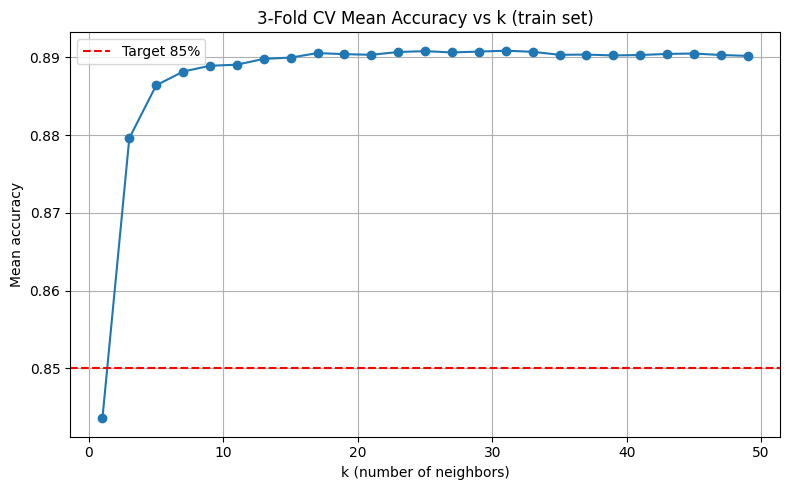

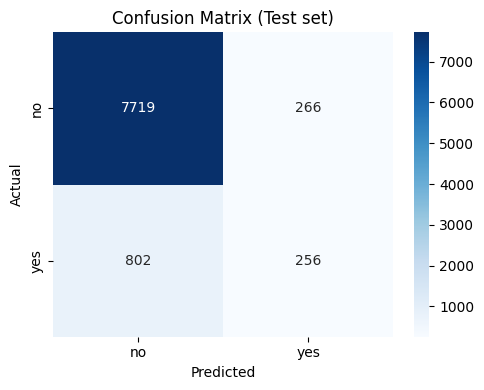

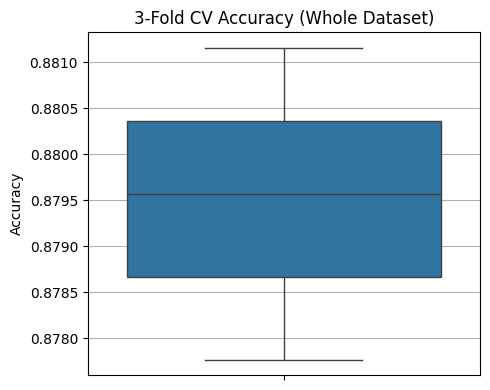


=== 3-FOLD CV на всьому наборі ===
CV accuracies: [0.87957004 0.88115461 0.8777704 ]
Mean accuracy: 0.8795, std: 0.0014

=== ВИСНОВКИ ===
- Існує k=3 з CV (3-fold on train) accuracy >= 0.85 (mean 0.8796).
- Обране k = 3, weights = uniform
- Точність на тесті (20% hold-out) = 0.8819
- 3-fold CV по всій вибірці mean accuracy = 0.8795 (std 0.0014)
- Модель досягає бажаної точності >= 85% на тесті.


In [ ]:
els=['no','yes'])
plt.title('Confusion Matrix (Test set)')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.tight_layout()
plt.show()

# === 13. 3-Fold CV на всьому наборі ===
whole_pipe = Pipeline(steps=[('pre', preprocessor),
                             ('knn', KNeighborsClassifier(n_neighbors=int(chosen_k),
                                                          weights=chosen_weights, n_jobs=-1))])
cv_scores = cross_val_score(whole_pipe, X, y, cv=cv, scoring='accuracy', n_jobs=-1)

plt.figure(figsize=(5,4))
sns.boxplot(y=cv_scores)
plt.title('3-Fold CV Accuracy (Whole Dataset)')
plt.ylabel('Accuracy')
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

print("\n=== 3-FOLD CV на всьому наборі ===")
print(f"CV accuracies: {cv_scores}")
print(f"Mean accuracy: {cv_scores.mean():.4f}, std: {cv_scores.std():.4f}")

# === 14. Висновки ===
print("\n=== ВИСНОВКИ ===")
if k_meets:
    print(f"- Існує k={chosen_k} з CV (3-fold on train) accuracy >= 0.85 (mean {chosen_k_score:.4f}).")
else:
    print("- Не знайдено k з CV (3-fold on train) accuracy >= 0.85; обрано k з найкращою CV точністю.")
print(f"- Обране k = {chosen_k}, weights = {chosen_weights}")
print(f"- Точність на тесті (20% hold-out) = {test_acc:.4f}")
print(f"- 3-fold CV по всій вибірці mean accuracy = {cv_scores.mean():.4f} (std {cv_scores.std():.4f})")
if test_acc >= 0.85:
    print("- Модель досягає бажаної точності >= 85% на тесті.")
else:
    print("- Модель НЕ досягає бажаної точності 85% на тесті.")